In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite as bi
from scipy.sparse import linalg
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.linalg import fractional_matrix_power

In [65]:
m,x,y = large_temporal_graph("outfile28.txt", [0.2])

=============================-
73 71 71 58 58
eigs
len_edge 558
[0.2]


In [59]:
# for i in range(len(e1)):
# print(h_map[e1[99]], l_map[e2[99]])
# print(h_map[e1[1756]], l_map[e2[1756]])
# a = sparse.diags([1]*(2+3))
# b = csr_matrix((5,5))
# a*b
# x,y
bipartite_graph("outfile28.txt", delta=0.2)
# a = np.array([range(10)]).reshape(10,1)
# b = np.array([range(10)]).reshape(1,10)
# a,b
# a1 = a.flatten()
# b1 = b.flatten()
# a1,b1

['1010133w' '1010151w' '1010229w' '1010145w' '1010119w'] ['1000012528l' '1000012521l' '1000012537l' '1000012527l' '1000012514l']
loc 58 wor 71 (71, 58)


1.569221255194567

In [64]:
def SIR_simulation(fname,transmission_prob, ini_h, ini_l, num_loop, infected_time, remove_edges=[]):
    status_h, status_l, days = extract_data(fname,remove_edges)
    results = []
    peaks = []
   
    for i in range(num_loop):
        num_infected = []
#         print(status_h,status_l)
        status_h, status_l, time_h, time_l, at_least_one = initial_status(status_h, status_l, ini_h, ini_l)
#         print(sum(status_h.values()), sum(status_l.values()))
        for day in days:
            for visit in day:
                hcw, loc, duration = visit[5]+"w", visit[7]+"l", visit[4]
                if status_h[hcw]==1 and status_l[loc]==0:
                    if np.random.rand()< get_long_exposure_prob(int(duration), transmission_prob):
                        status_l[loc]=1
                        time_l[loc]=1
                        at_least_one.add(loc)
                elif status_h[hcw]==0 and status_l[loc]==1:
                    if np.random.rand()< get_long_exposure_prob(int(duration), transmission_prob):
                        status_h[hcw]=1
                        time_h[hcw]=1
                        at_least_one.add(hcw)
            status_h, status_l, time_h, time_l = update_status(status_h, status_l, time_h, time_l, infected_time)
            total_infected = list(status_h.values()).count(1) + list(status_l.values()).count(1)
            num_infected.append(total_infected)
        results.append(len(at_least_one)/(len(status_h)+len(status_l)))
#         print(num_infected)
        peaks.append(np.max(num_infected))
        for key in status_h.keys():
            status_h[key]=0
        for key in status_l.keys():
            status_l[key]=0
    return results,peaks


def extract_data(fname, remove_edges=[]):
#     fname = "outfile28.txt"
    infile = open(fname, "r")
    infection_status_h = {}
    infection_status_l = {}
    days = []
    visits = []
    next(infile)
    current = -1
    remove_edges = set(remove_edges)
    for line in infile:
        line = line.strip()
        line = line.split()
#         print(line)
        if line[0] not in days:
            current +=1
            days.append(line[0])
            visits.append([])
        try:
            infection_status_h[line[5]+"w"] = 0
            infection_status_l[line[7]+"l"] = 0
        except IndexError:
            print(line)
            return
        if (line[5]+"w",line[7]+"l") not in remove_edges:
            visits[current].append(line)
        
    return infection_status_h,infection_status_l,visits

def large_temporal_graph(fname, alphas, transmission_prob=0.2):
    print("=============================-")
    infile = open(fname, "r")
    days = []
    visits = []
    h_nodes={}
    l_nodes={}
    h_map = {}
    l_map = {}
    len_h=0
    len_l=0
    next(infile)
    current = -1
    for line in infile:
        line = line.strip()
        line = line.split()
#         print(line)
        if line[0] not in days:
            current +=1
            days.append(line[0])
            visits.append([])
        if line[5]+"w" not in h_nodes.keys():
            h_nodes[line[5]+"w"]=len_h
            h_map[len_h] = line[5]+"w"
            len_h+=1
        if line[7]+"l" not in l_nodes.keys():
            l_nodes[line[7]+"l"]=len_l
            l_map[len_l] = line[7]+"l"
            len_l+=1
        visits[current].append((line[5]+"w",line[7]+"l",get_long_exposure_prob(int(line[4]), transmission_prob)))
        
    mtx = csr_matrix((0,0))
    h_size = len(h_nodes)
    l_size = len(l_nodes)
#     print("======",h_size,l_size)
    day_size = len(visits)
    print(day_size, h_size,len_h, l_size,len_l)
    row = []
    col = []
    val = {}
    edge_set=[]
    edges = [[],[]]
    weight = []
    count = 0
    sys = sparse.diags([1]*(h_size+l_size))
    
    for day in visits:
        eye = sparse.identity(h_size+l_size)
        right_zero = csr_matrix((l_size,l_size))
        left_zero = csr_matrix((h_size,h_size))
        for visit in day:
            if (h_nodes[visit[0]],l_nodes[visit[1]]) not in val.keys():
                val[(h_nodes[visit[0]],l_nodes[visit[1]])]=1-visit[2]
                if (h_nodes[visit[0]],l_nodes[visit[1]]) not in edge_set:
                    edge_set.append((h_nodes[visit[0]],l_nodes[visit[1]]))
                    edges[0].append(h_nodes[visit[0]])
                    edges[1].append(l_nodes[visit[1]])
            else:
                val[(h_nodes[visit[0]],l_nodes[visit[1]])]*=(1-visit[2])
        for key in val.keys():
            row.append(key[0])
            col.append(key[1])
            weight.append(1-val[key])
        B = csr_matrix((weight, (row, col)), shape=(h_size, l_size))
        B_t = B.transpose()
        right = sparse.vstack((B,right_zero))
        left = sparse.vstack((left_zero,B_t))
        A = sparse.hstack((left,right))
        sys = sys*(sparse.diags([1]*(h_size+l_size))+A)
        
        if count!=day_size-1:
            A = sparse.hstack((A,eye))
            for i in range(count):
                zero = csr_matrix((l_size+h_size,l_size+h_size))
                A = sparse.hstack((zero,A))
            for j in range(day_size-count-2):
                zero = csr_matrix((l_size+h_size,l_size+h_size))
                A = sparse.hstack((A,zero))
        else:
            zero=csr_matrix((l_size+h_size,(l_size+h_size)*(day_size-1)))
            A = sparse.hstack((zero,A))
            
        mtx = sparse.vstack((mtx,A))
        col = []
        row = []
        val = {}
        weight = []
        count+=1
    
    x = linalg.eigs(mtx, k=1)
    y = linalg.eigs(sys, k=1)
    print("eigs")
    
    centrality1 = []
    centrality2 = []
    centrality_a = 0
    centrality_b = 0
    centrality_dot = 0
    vec_a = []
    vec_b = []
    node_centrality_h={}
    node_centrality_l={}
    for i in range(h_size):
        vec_a.append([])
        for j in range(day_size):
            a = np.abs(x[1][i+(h_size+l_size)*j][0])
            vec_a[i].append(a)
            if j == 0:
                node_centrality_h[i] = a
            else:
                node_centrality_h[i]+= a
            
    for i in range(l_size):
        vec_b.append([])
        for j in range(day_size):
            b = np.abs(x[1][(i+h_size)+(h_size+l_size)*j][0])
            vec_b[i].append(b)
            if j == 0:
                node_centrality_l[i] = b
            else:
                node_centrality_l[i]+= b
    
    print("len_edge", len(edges[0]))
            
    for i in range(len(edges[0])):
        centrality1.append(node_centrality_h[edges[0][i]]*node_centrality_l[edges[1][i]])
        centrality2.append(np.dot(vec_a[edges[0][i]],vec_b[edges[1][i]]))
            
#     for i in range(len(edges[0])):
#         print("edge"+str(i))
#         for j in range(day_size):

#             a = np.abs(x[1][edges[0][i]+(h_size+l_size)*j][0])
#             b = np.abs(x[1][edges[1][i]+h_size+(h_size+l_size)*j][0])
            
#             centrality_dot+=a*b
#             centrality_a+=a
#             centrality_b+=b
#         centrality1.append(centrality_a*centrality_b)
#         centrality2.append(centrality_dot)
#         centrality_a = 0
#         centrality_b = 0
#         centrality_dot = 0
    alpha_dic = {}
    print(alphas)
    for alpha in alphas:
        num = int(len(edges[0])*alpha)
#         print(len(edges[0]), centrality1)
        summation = np.argsort(-np.array(centrality1))[:num]
        dot = np.argsort(-np.array(centrality2))[:num]
#         print(summation)
        s = []
        d = []
        
#         print("sum")
#         for i in summation:
#             (s.append((list(h_nodes.keys())[list(h_nodes.values()).index(edges[0][i])],
#                        list(l_nodes.keys())[list(l_nodes.values()).index(edges[1][i])])))
#         print("dot")
#         for j in dot:
#             (d.append((list(h_nodes.keys())[list(h_nodes.values()).index(edges[0][j])],
#                        list(l_nodes.keys())[list(l_nodes.values()).index(edges[1][j])])))
#         alpha_dic[alpha] = s,d
#         print("alpha",alpha)
    
        for i in summation:
#             print("i",i, "h",h_map[edges[0][i]], "l", l_map[edges[1][i]])
            s.append((h_map[edges[0][i]],l_map[edges[1][i]]))
        
        for i in dot:
            d.append((h_map[edges[0][i]],l_map[edges[1][i]]))
        alpha_dic[alpha] = s,d
        
#         print(edges)
    return alpha_dic, x[0],y[0]
                    
                    
def bipartite_graph(fname, delta=0.2):
#     fname = "outfile28.txt"
    infile = open(fname, "r")
    wor_set = {}
    loc_set = {}
    wor_map = {}
    loc_map = {}
    len_w = 0
    len_l = 0
    edge_dic = {}
    edge_list = []
    
    next(infile)
    for line in infile:
        line = line.strip()
        line = line.split()
        
        if line[5]+"w" not in wor_set.keys():
            wor_set[line[5]+"w"]=len_w
            wor_map[len_w] = line[5]+"w"
            len_w+=1
        if line[7]+"l" not in loc_set.keys():
            loc_set[line[7]+"l"] = len_l
            loc_map[len_l] = line[7]+"l"
            len_l+=1
        akey = (line[5]+"w",line[7]+"l")

        if akey in edge_dic.keys():
            edge_dic[akey]+= get_long_exposure_prob(int(line[4]),delta)
        else:
            edge_dic[akey]=get_long_exposure_prob(int(line[4]),delta)

    for key,val in edge_dic.items():
        lst = list(key)
        lst.append(val)
        tpl = tuple(lst)
        edge_list.append(tpl)
    G = nx.Graph()
    wor_list = np.array(list(wor_set.keys()))
    loc_list = np.array(list(loc_set.keys()))
    G.add_nodes_from(wor_list, bipartite=0)
    G.add_nodes_from(loc_list, bipartite=1)
    G.add_weighted_edges_from(edge_list)
    avg_clustering_coeff = bi.average_clustering(G)
#     print("degree", bi.degrees(G, G.nodes()))
    print(wor_list[:5],loc_list[:5])
    row=[]
    col=[]
    weights = []
    for key in edge_dic.keys():
            row.append(wor_set[key[0]])
            col.append(loc_set[key[1]])
            weights.append(edge_dic[key])
#     mean_degree = np.mean(weights)
    
    B = csr_matrix((weights, (row, col)), shape=(len_w, len_l))
    a = np.mean(B,axis=0)
#     a = a.flatten()
    b = np.mean(B,axis=1)
    b = b.flatten()
#     print("aaaaaaa",a.shape,np.mean(a[0]))
#     print("bbbbbbb",b.shape,np.mean(b[0]))
    mean_degree = (np.mean(a[0])+np.mean(b[0]))/2
    nonzeros = B.nonzero()
    B_t = B.transpose()
    
    print("loc", len(loc_set),"wor", len(wor_set), B.shape)

    right_zero = csr_matrix((len(loc_set),len(loc_set)))
    left_zero = csr_matrix((len(wor_set),len(wor_set)))
    right = sparse.vstack((B,right_zero))
    left = sparse.vstack((left_zero,B_t))
    A = sparse.hstack((left,right))
    
    edges = (nonzeros[0],nonzeros[1])
    
    ### B is len(people) by len(location)
    ###A = [0 B]
#         [B'0]
    
#     return (np.max(np.abs(linalg.eigs(A,k=1)[0])), avg_clustering_coeff, mean_degree, weights, edges,
#            wor_map, loc_map)
    return mean_degree


def initial_status(hcw,loc,num_h, num_l):
    len_h = len(hcw)
    len_l = len(loc)
    time_h = {}
    time_l = {}
    print(len_h, len_l)
    infection_set = set()
    while sum(hcw.values()) < num_h and len(time_h) < len_h:
        key = list(hcw.keys())[np.random.randint(0,len_h)]
        infection_set.add(key)
        hcw[key] = 1
        time_h[key]=1
    while sum(loc.values()) < num_l and len(time_l) < len_l:
        key = list(loc.keys())[np.random.randint(0,len_l)]
        infection_set.add(key)
        loc[key]=1
        time_l[key]=1
#     print(infection_set)
    return hcw,loc, time_h, time_l, infection_set

def update_status(s_h, s_l, t_h, t_l, time):
    tl_key = list(t_l.keys())
    th_key = list(t_h.keys())
    for key in th_key:
        t_h[key]+=1
        if t_h[key]==time:
            t_h.pop(key)
            s_h[key] = 2
    for key in tl_key:
        t_l[key]+=1
        if t_l[key]==time:
            t_l.pop(key)
            s_l[key] = 2
    return s_h, s_l, t_h, t_l

def get_long_exposure_prob(visit_duration, trans_prob):

    long_exposure_trans_prob = 1 - np.math.pow((1 - trans_prob), np.math.ceil(visit_duration / 30)) # 30 seconds

    return long_exposure_trans_prob


all_results = []
graph_lst = [6,7,8,9,10,11,12,13,14,15,16,19,20,21,22,23,24,25,28,29,31,32,33,34,36,37,38,39,40,41,42,43,44,45]
degrees = []
c_coeffs = []
eigenvalues=[]
for i in graph_lst:
    print(i)
    fname = "outfile"+str(i)+".txt"

6
7
8
9
10
11
12
13
14
15
16
19
20
21
22
23
24
25
28
29
31
32
33
34
36
37
38
39
40
41
42
43
44
45


558 167
=============================-
73 71 58
[0.3]
2292
alpha 0.3
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58


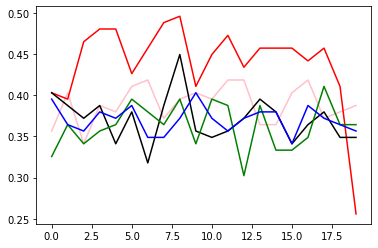

In [312]:
# a,b,c,weight,edge,wor,loc = bipartite_graph("outfile28.txt")
choosen = rand_edge(e,0.3)
choosen2 = highest_weight(e,weight,0.3)
x = mapping_edges(e,choosen,wor,loc)
y = mapping_edges(e,choosen2, wor, loc)
c = large_temporal_graph("outfile28.txt",[0.3])
r,r2 = SIR_simulation("outfile28.txt", 0.2,10, 10, 20, 4, x)
n,n2 = SIR_simulation("outfile28.txt", 0.2,10, 10, 20, 4)
hw,hw2 = SIR_simulation("outfile28.txt", 0.2,10, 10, 20, 4, y)
c11,c12 = SIR_simulation("outfile28.txt", 0.2,10, 10, 20, 4, c[0.3][0])
c21, c22 = SIR_simulation("outfile28.txt", 0.2,10, 10, 20, 4, c[0.3][1])
plt.plot(r, c="pink")
plt.plot(n, c="red")
plt.plot(hw, c="black")
plt.plot(c11, c="green")
plt.plot(c21, c="blue")

In [66]:
a = [1,2,3,45,1,2]
np.median(a)

2.0

In [3]:
def rand_edge(edges, alpha):
    
    ##edges = ([rows], [cols])
    choosen =[]
    len_e = len(edges[0])
    num = int(len_e*alpha)
    while len(choosen) < num:
        edge_idx = np.random.randint(0,len_e)
        if edge_idx not in choosen:
            choosen.append(edge_idx)
    return choosen

def highest_weight(edges, weights, alpha):
#     data ="[row,col,weights]"
    choosen =[]
    len_e = len(edges[0])
    num = int(len_e*alpha)
    print(len_e,num)
    args = np.argsort(-np.array(weights))[:num]
    
#     for i in args:
#         print(A[edges[0][i],edges[1][i]])
    
    return args

def mapping_edges(edges,edge_args,wor_map,loc_map):
    remove_edge_list=[]
    for i in edge_args: 
#         print(edges[0][i],"aaaaa")
        remove_edge_list.append((wor_map[edges[0][i]],loc_map[edges[1][i]]))
    return remove_edge_list

def remove_edges(A,edges,edge_args):
    len_e = len(edges[0])
    for i in range(len_e):
        if i in edge_args:
#             print(A[edges[0][i],edges[1][i]]!=0)
            A[edges[0][i],edges[1][i]]=0
    return A

def SIR_static(adj, ini,infected_time,max_time ):
    ##edges[2]=normalized weight
    vertex = list(range(adj.shape[0]))
            
    idx = []
    while len(idx)<ini and len(idx) != len(vertex):
        num = np.random.randint(len(vertex))
        if num not in idx:
            idx.append(num)
    vec = {}
    time_infected = {}
    ever_infected = {}
    for i in range(len(vertex)):
        if i in idx:
            vec[vertex[i]]=1
            time_infected[vertex[i]]=1
            ever_infected[vertex[i]]=1
        else:
            vec[vertex[i]]=0
    num_infected = []
    num_infected.append(sum(vec.values()))
    for x in range(max_time):
        for i in vertex:
            for nei in vertex:
                if vec[i]==1 and vec[nei]==0:
                    if np.random.rand()<adj[i,nei]:
                        vec[nei]=1
                        time_infected[nei]=1
                        ever_infected[nei]=1
        time_infected,vec = update_time(time_infected,vec,infected_time)
        num_infected.append(list(vec.values()).count(1))
    return np.max(num_infected), list(ever_infected.values()).count(1)
def update_time(time_vec,status_vec,recover_time):
    keys = list(time_vec.keys())
    for key in keys:
        time_vec[key]+=1
        if time_vec[key]==recover_time:
#             print("recover")
            time_vec.pop(key)
            status_vec[key] = 2
    return time_vec, status_vec

def normalize_lap(adj_mtx):
    d_entry = np.sum(adj_mtx,axis=1)
    d = np.squeeze(np.asarray(d_entry))
    d = np.diag(d)
#     print(d.shape)
    d_neg_half = fractional_matrix_power(d,-0.5)
#     print(d_neg_half)
    return d_neg_half@adj_mtx@d_neg_half

In [197]:
# a,b,c,mtx,e = bipartite_graph("outfile8.txt") ##d=mtx, e=edge
a = np.array([1,3,4,9,1,6])
np.argsort(-a)
row = np.array([0, 1, 2, 0])
col = np.array([0, 1, 1, 1])
data = np.array([1, 2, 4, 8])
csr = csr_matrix((data, (row, col)), shape=(3, 3))
zero = np.zeros((3,3))
csr = sparse.hstack((csr,zero))
csr.data

array([1., 8., 2., 4.])

In [27]:
d = normalize_lap(mtx)
d_r = d.copy()
d_hw = d.copy()
r = highest_weight(e,d_r,0.7)
h_w = remove_edges(d_hw,e,r)
ran = rand_edge(e,0.7)
ran_removed = remove_edges(d_r,e,ran)

8757 6129


In [28]:
np.count_nonzero(d), np.count_nonzero(h_w), np.count_nonzero(ran_removed)

(17514, 11385, 11385)

In [29]:
original = SIR_static(d,30,10,50)
removed = SIR_static(h_w,30,10,50)
removed_ran = SIR_static(ran_removed,30,10,50)
original, removed, removed_ran

((228, 234), (117, 172), (190, 224))

In [101]:
peak = [original[0]-removed[0],original[0]-removed_ran[0]]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar([0,1],peak, align="center",alpha=0.5)
ax.set_xticks([0,1])
ax.set_xticklabels(["highest degree","highest rand"])
ax.set_ylabel("difference in peak")

NameError: name 'original' is not defined

In [14]:
graph_lst = [9,10,11]
alphas = [0.1, 0.3, 0.5, 0.7]

for graph in graph_lst:
    print(graph)
    fname = "outfile"+str(graph)+".txt"
    ei,c_coeff, deg, mtx, edges = bipartite_graph(fname)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    title = "graph"+str(graph)
    fig.suptitle(title, fontsize=20)
    for alpha in alphas:
        print(alpha)
        mtx = normalize_lap(mtx)
        h_w = highest_weight(edges,mtx,alpha)
        h_w_mtx = remove_edges(mtx,edges,h_w)
        ran = rand_edge(edges,alpha)
        ran_mtx = remove_edges(mtx,edges,ran)
        original = SIR_static(mtx,30,10,50)
        removed_h_w = SIR_static(h_w_mtx,30,10,50)
        removed_ran = SIR_static(ran_mtx,30,10,50)
        ori_label = "original"+str(alpha)
        ran_label = "random"+str(alpha)
        hw_label = "highest_weight" + str(alpha)
        ax.plot(original, label=ori_label)
        ax.plot(removed_ran, label=ran_label)
        ax.plot(removed_h_w, label=hw_label)
        name = title+".png"
        plt.legend()
        fig.savefig(name)
    plt.close()

9


NameError: name 'bipartite_graph' is not defined

In [15]:
from scipy.linalg import fractional_matrix_power
# outfile = open("500results.txt", "w")
# a = [1,2,3]
# print(a,file=outfile)
# outfile.close()
c = np.arange(25).reshape(5,5)
c = np.array([
    [0,2,3],
    [2,0,4],
    [3,4,0]
])
d = np.diag([100,5, 10])
fractional_matrix_power(d,0.5)
normalize(c)[1,:]

NameError: name 'np' is not defined

In [12]:

a,b,c,d,e = bipartite_graph("outfile28.txt")

<bound method NodeView.data of NodeView(('1010117w', '1010110w', '1010169w', '1010170w', '1010122w', '1010241w', '1010247w', '1010112w', '1010157w', '1010131w', '1010113w', '1010189w', '1010178w', '1010230w', '1010140w', '1010136w', '1010234w', '1010213w', '1010248w', '1010179w', '1010201w', '1010219w', '1010108w', '1010217w', '1010167w', '1010124w', '1010249w', '1010116w', '1010221w', '1010109w', '1010141w', '1010093w', '1010144w', '1010214w', '1010149w', '1010148w', '1010111w', '1010151w', '1010138w', '1010220w', '1010236w', '1010227w', '1010233w', '1010222w', '1010152w', '1010244w', '1010143w', '1010197w', '1010105w', '1010097w', '1010099w', '1010175w', '1010119w', '1010160w', '1010190w', '1010133w', '1010134w', '1010229w', '1010121w', '1010208w', '1010102w', '1010104w', '1010176w', '1010145w', '1010114w', '1010196w', '1010192w', '1010206w', '1010161w', '1010243w', '1010135w', '1000012492l', '1000012524l', '1000012456l', '1000012495l', '1000012490l', '1000012516l', '1000012494l', '1

In [6]:
e

(array([ 0,  0,  0,  0,  0,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9, 10, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 12, 13, 13, 13, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,
        16, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 19, 19, 19, 19, 19, 20,
        20, 20, 21, 21, 21, 22, 23, 23, 23, 24, 25, 26, 26, 26, 26, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30,
        30, 

In [16]:
import networkx as nx
from networkx.algorithms import bipartite as bi
def bipartite_graph(fname, delta=0.2, scaling=1.1):
#     fname = "outfile28.txt"
    infile = open(fname, "r")
    wor_set = set()
    loc_set = set()
    edge_dic = {}
    edge_list = []
    
    next(infile)
    for line in infile:
        line = line.strip()
        line = line.split()
        wor_set.add(line[5]+"w")
        loc_set.add(line[7]+"l")
        akey = (line[5]+"w",line[7]+"l")
#         print(line[4])
        if akey in edge_dic.keys():
            edge_dic[akey]+= get_long_exposure_prob(int(line[4]),delta)
        else:
            edge_dic[akey]=get_long_exposure_prob(int(line[4]),delta)
#         print(edge_dic.values())
    for key,val in edge_dic.items():
        lst = list(key)
        lst.append(val)
        tpl = tuple(lst)
#         print(tpl)
        edge_list.append(tpl)
    G = nx.Graph()
    G.add_nodes_from(list(wor_set), bipartite=0)
    G.add_nodes_from(list(loc_set), bipartite=1)
    G.add_weighted_edges_from(edge_list)
#     print(G.edges.data("weight"))
    weights = []
    for data in G.edges.data("weight"):
        weights.append(data[2])
#     mean_degree = np.mean(list(dict(G.degree).values()))
    mean_degree = np.mean(weights)
#     print(G.nodes.data)
#     print(list(wor_set)) !!!! Mapping from actual node id to an index
    avg_clustering_coeff = bi.average_clustering(G)
    
    sparse_bimatrix = bi.biadjacency_matrix(G, list(wor_set))
    nonzeros = sparse_bimatrix.nonzero()
    print("nonzeros",nonzeros[0])
    B = sparse.csr_matrix.todense(sparse_bimatrix)
    B_t= np.transpose(B)
    
#     for i in range(len(nonzeros[0])):
#             print(B[nonzeros[0][i],nonzeros[1][i]])
    
    print("loc", len(loc_set),"wor", len(wor_set), B.shape)
#     print(nonzeros[0],nonzeros[1]+len(wor_set))
    right_zero = np.zeros((len(loc_set),len(loc_set)))
    left_zero = np.zeros((len(wor_set),len(wor_set)))
#     print(right_zero.shape, left_zero.shape)
    right = np.concatenate((B,right_zero),axis=0)
    left = np.concatenate((left_zero,B_t),axis=0)
    A = np.concatenate((left,right), axis=1)
    
#     for i in range(len(nonzeros[0])):
#             print(A[nonzeros[0][i],nonzeros[1][i]+len(wor_set)])
    edges = (nonzeros[0],nonzeros[1]+len(wor_set))
    
    ### B is len(people) by len(location)
    ###A = [0 B]
#         [B'0]
    
    return np.max(np.abs(np.linalg.eigvals(A).real)), avg_clustering_coeff, mean_degree, A, edges

def initial_status(hcw,loc,num_h, num_l):
    len_h = len(hcw)
    len_l = len(loc)
    time_h = {}
    time_l = {}
    while sum(hcw.values()) < num_h:
        key = list(hcw.keys())[np.random.randint(0,len_h)]
        hcw[key] = 1
        time_h[key]=1
    while sum(loc.values()) < num_l:
        key = list(loc.keys())[np.random.randint(0,len_l)]
        loc[key]=1
        time_l[key]=1
    return hcw,loc, time_h, time_l

def update_status(s_h, s_l, t_h, t_l, time):
    tl_key = list(t_l.keys())
    th_key = list(t_h.keys())
    for key in th_key:
        t_h[key]+=1
        if t_h==time:
            t_h.pop(key)
            s_h[key] = 2
    for key in tl_key:
        t_l[key]+=1
        if t_l[key]==time:
            t_l.pop(key)
            s_l[key] = 2
    return s_h, s_l, t_h, t_l
            
            

In [17]:
a,b,c,d,e = bipartite_graph("outfile28.txt")

<bound method NodeView.data of NodeView(('1010117w', '1010110w', '1010169w', '1010170w', '1010122w', '1010241w', '1010247w', '1010112w', '1010157w', '1010131w', '1010113w', '1010189w', '1010178w', '1010230w', '1010140w', '1010136w', '1010234w', '1010213w', '1010248w', '1010179w', '1010201w', '1010219w', '1010108w', '1010217w', '1010167w', '1010124w', '1010249w', '1010116w', '1010221w', '1010109w', '1010141w', '1010093w', '1010144w', '1010214w', '1010149w', '1010148w', '1010111w', '1010151w', '1010138w', '1010220w', '1010236w', '1010227w', '1010233w', '1010222w', '1010152w', '1010244w', '1010143w', '1010197w', '1010105w', '1010097w', '1010099w', '1010175w', '1010119w', '1010160w', '1010190w', '1010133w', '1010134w', '1010229w', '1010121w', '1010208w', '1010102w', '1010104w', '1010176w', '1010145w', '1010114w', '1010196w', '1010192w', '1010206w', '1010161w', '1010243w', '1010135w', '1000012492l', '1000012524l', '1000012456l', '1000012495l', '1000012490l', '1000012516l', '1000012494l', '1

In [39]:
graph_lst = [28]
alphas = [0.1, 0.3, 0.5, 0.7]

for graph in graph_lst:
    print(graph)
    fname = "outfile"+str(graph)+".txt"
    ei,c_coeff, deg, mtx, edges = bipartite_graph(fname)
    mtx = normalize_lap(mtx)
    original_peak, original_total = SIR_static(mtx,30,10,50)
    peaks_h = []
    peaks_ran = []
    totals_h = []
    totals_ran = []
    for alpha in alphas:
        mtx_hw = mtx.copy()
        h_w = highest_weight(edges,mtx_hw,alpha)
        h_w_mtx = remove_edges(mtx_hw,edges,h_w)

        mtx_ran = mtx.copy()
        ran = rand_edge(edges,alpha)
        ran_mtx = remove_edges(mtx_ran,edges,ran)

        peak_h, total_h = SIR_static(h_w_mtx,30,10,50)
        peak_ran, total_ran = SIR_static(ran_mtx,30,10,50)

        peaks_h.append(original_peak-peak_h)
        peaks_ran.append(original_peak-peak_ran)
        totals_h.append(original_total-total_h)
        totals_ran.append(original_total-total_ran)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    title = "graph: "+str(graph)+ " method: highest weight, peak"
    fig.suptitle(title, fontsize=20)
    ax.bar([0,1,2,3],peaks_h, align="center",alpha=0.5)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(["0.1", "0.3", "0.5", "0.7"])
    ax.set_ylabel("difference in peak")
    name = title+".png"
    fig.savefig("aaa.png")
    plt.close()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    title = "graph_"+str(graph)+ "method_random_peak"
    fig.suptitle(title, fontsize=20)
    ax.bar([0,1,2,3],peaks_ran, align="center",alpha=0.5)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(["0.1", "0.3", "0.5", "0.7"])
    ax.set_ylabel("difference in peak")
    name = title+".png"
    fig.savefig(name)
    plt.close()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    title = "graph: "+str(graph)+ " method: highest weight, total"
    fig.suptitle(title, fontsize=20)
    ax.bar([0,1,2,3],totals_h, align="center",alpha=0.5)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(["0.1", "0.3", "0.5", "0.7"])
    ax.set_ylabel("difference in total")
    name = title+".png"
    fig.savefig("ccc.png")
    plt.close()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    title = "graph: "+str(graph)+ " method: random, total"
    fig.suptitle(title, fontsize=20)
    ax.bar([0,1,2,3],totals_ran, align="center",alpha=0.5)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(["0.1", "0.3", "0.5", "0.7"])
    ax.set_ylabel("difference in total")
    name = title+".png"
    fig.savefig("ddd.png")
    plt.close()

    name = "graph: "+str(graph)+ " static data.txt"
    outfile = open(name, "w")
    print("original_peak",original_peak, file=outfile)
    print("original_total",original_total, file=outfile)
    print("random_peak",peaks_ran, file=outfile)
    print("highest_weight_peak",peaks_h, file=outfile)
    print("random_total",totals_ran, file=outfile)
    print("highest_weight_total",totals_h, file=outfile)

    outfile.close()


28
nonzeros 558
loc 58 wor 71 (71, 58)
558 55
558 167
558 279
558 390


In [ ]:
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from([1, 2, 3, 4], bipartite=0)
B.add_nodes_from(["a", "b", "c"], bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from([(1, "a"), (1, "b"), (2, "b"), (2, "c"), (3, "c"), (4, "a")])
bipartite.is_bipartite(B)

In [ ]:
# np.mean(list(dict(bi.degrees(B)).values()))
bi.average_clustering(B)

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite as bi

In [33]:
bi.degrees(B,[])

(DegreeView({1: 2, 2: 2, 3: 1, 4: 1, 'b': 2, 'a': 2, 'c': 2}), DegreeView({}))

In [31]:
B.degree()

DegreeView({1: 2, 2: 2, 3: 1, 4: 1, 'a': 2, 'b': 2, 'c': 2})

In [61]:
from scipy import sparse as sp
bi.biadjacency_matrix(B, [1, 2, 3, 4])

<4x3 sparse matrix of type '<class 'numpy.intc'>'
	with 6 stored elements in Compressed Sparse Row format>

In [18]:
from scipy import linalg
from scipy import sparse

B1 = sparse.csr_matrix.todense(bi.biadjacency_matrix(B, [1, 2, 3, 4]))
B1_t= np.transpose(B1)
B1_t

NameError: name 'B' is not defined

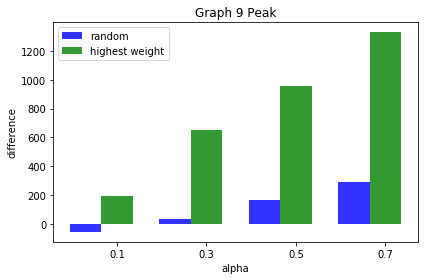

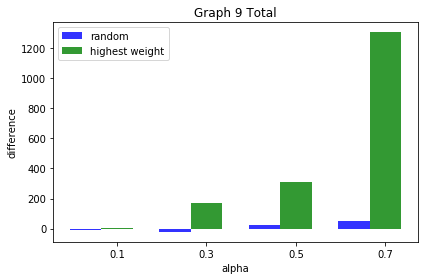

In [33]:
dic={}
infile = open("graph_9_static_data.txt", "r")
for line in infile:
    line = line.strip()
    line = line.split(" ")
    lst = []
    for item in line[1:]:
        item = item.strip(",")
        item = item.strip("]")
        item = item.strip("[")
        lst.append(int(item))
    dic[line[0]]=lst

alpha = np.array(["0.1","0.3", "0.5", "0.7"])
index = np.array([0,1,2,3])
opacity=0.8
bar_width=0.35
fig, ax = plt.subplots()


rects1 = plt.bar(index, dic["random_peak"], bar_width,
alpha=opacity,
color='b',
label='random')

rects2 = plt.bar(index+bar_width, dic["highest_weight_peak"], bar_width,
alpha=opacity,
color='g',
label='highest weight')

plt.xlabel('alpha')
plt.ylabel('difference')
plt.title('Graph 9 Peak')
plt.xticks(index + bar_width, alpha)
plt.legend()

plt.tight_layout()
plt.show()
dic["random_peak"]
fig.savefig("grpah_9_peak.png")

fig, ax = plt.subplots()

rects1 = plt.bar(index, dic["random_total"], bar_width,
alpha=opacity,
color='b',
label='random')

rects2 = plt.bar(index+bar_width, dic["highest_weight_total"], bar_width,
alpha=opacity,
color='g',
label='highest weight')

plt.xlabel('alpha')
plt.ylabel('difference')
plt.title('Graph 9 Total')
plt.xticks(index + bar_width, alpha)
plt.legend()

plt.tight_layout()
plt.show()
# dic["random_peak"]
fig.savefig("grpah_9_total.png")


infile.close()

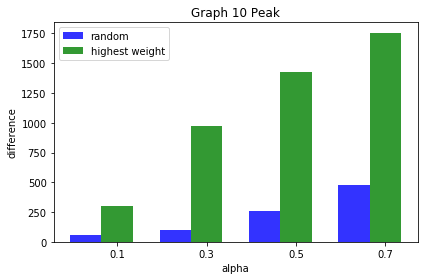

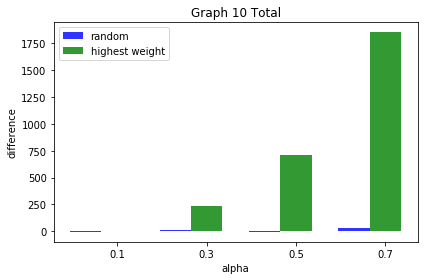

In [34]:
dic={}
infile = open("graph_10_static_data.txt", "r")
for line in infile:
    line = line.strip()
    line = line.split(" ")
    lst = []
    for item in line[1:]:
        item = item.strip(",")
        item = item.strip("]")
        item = item.strip("[")
        lst.append(int(item))
    dic[line[0]]=lst

alpha = np.array(["0.1","0.3", "0.5", "0.7"])
index = np.array([0,1,2,3])
opacity=0.8
bar_width=0.35
fig, ax = plt.subplots()


rects1 = plt.bar(index, dic["random_peak"], bar_width,
alpha=opacity,
color='b',
label='random')

rects2 = plt.bar(index+bar_width, dic["highest_weight_peak"], bar_width,
alpha=opacity,
color='g',
label='highest weight')

plt.xlabel('alpha')
plt.ylabel('difference')
plt.title('Graph 10 Peak')
plt.xticks(index + bar_width, alpha)
plt.legend()

plt.tight_layout()
plt.show()
dic["random_peak"]
fig.savefig("grpah_10_peak.png")

fig, ax = plt.subplots()

# dic["random_total"][0]=-10
rects1 = plt.bar(index, dic["random_total"], bar_width,
alpha=opacity,
color='b',
label='random')

# dic["highest_weight_total"][0]=5
rects2 = plt.bar(index+bar_width, dic["highest_weight_total"], bar_width,
alpha=opacity,
color='g',
label='highest weight')

plt.xlabel('alpha')
plt.ylabel('difference')
plt.title('Graph 10 Total')
plt.xticks(index + bar_width, alpha)
plt.legend()

plt.tight_layout()
plt.show()
# dic["random_peak"]
fig.savefig("grpah_10_total.png")


infile.close()

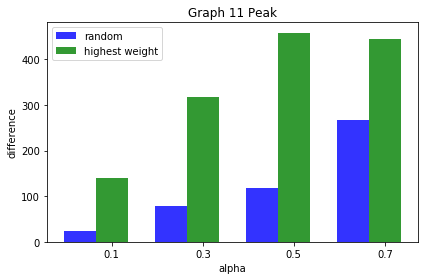

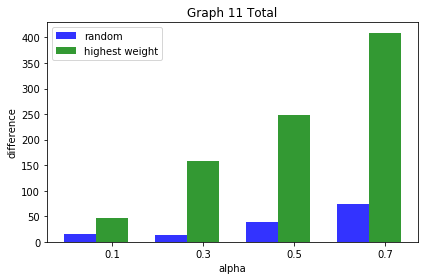

In [35]:
dic={}
infile = open("graph_11_static_data.txt", "r")
for line in infile:
    line = line.strip()
    line = line.split(" ")
    lst = []
    for item in line[1:]:
        item = item.strip(",")
        item = item.strip("]")
        item = item.strip("[")
        lst.append(int(item))
    dic[line[0]]=lst

alpha = np.array(["0.1","0.3", "0.5", "0.7"])
index = np.array([0,1,2,3])
opacity=0.8
bar_width=0.35
fig, ax = plt.subplots()


rects1 = plt.bar(index, dic["random_peak"], bar_width,
alpha=opacity,
color='b',
label='random')

rects2 = plt.bar(index+bar_width, dic["highest_weight_peak"], bar_width,
alpha=opacity,
color='g',
label='highest weight')

plt.xlabel('alpha')
plt.ylabel('difference')
plt.title('Graph 11 Peak')
plt.xticks(index + bar_width, alpha)
plt.legend()

plt.tight_layout()
plt.show()
dic["random_peak"]
fig.savefig("grpah_11_peak.png")

fig, ax = plt.subplots()

# dic["random_total"][0]=-10
rects1 = plt.bar(index, dic["random_total"], bar_width,
alpha=opacity,
color='b',
label='random')

# dic["highest_weight_total"][0]=5
rects2 = plt.bar(index+bar_width, dic["highest_weight_total"], bar_width,
alpha=opacity,
color='g',
label='highest weight')

plt.xlabel('alpha')
plt.ylabel('difference')
plt.title('Graph 11 Total')
plt.xticks(index + bar_width, alpha)
plt.legend()

plt.tight_layout()
plt.show()
# dic["random_peak"]
fig.savefig("grpah_11_total.png")


infile.close()

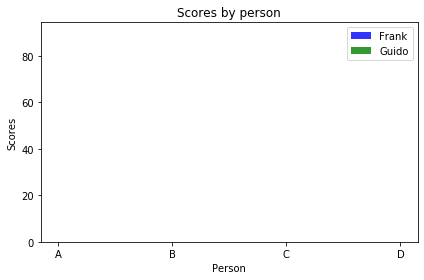

In [9]:
n_groups = 4
means_frank = (90, 55, 40, 65)
means_guido = (85, 62, 54, 20)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.
opacity = 0.8



rects1 = plt.bar(index, means_frank, bar_width,
alpha=opacity,
color='b',
label='Frank')

rects2 = plt.bar(index + bar_width, means_guido, bar_width,
alpha=opacity,
color='g',
label='Guido')

plt.xlabel('Person')
plt.ylabel('Scores')
plt.title('Scores by person')
plt.xticks(index + bar_width, ('A', 'B', 'C', 'D'))
plt.legend()

plt.tight_layout()
plt.show()

28
loc 58 wor 71 (71, 58)
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
=============================-
73 71 58
[0.1, 0.3, 0.5, 0.7]
2292
alpha 0.1
2292
alpha 0.3
2292
alpha 0.5
2292
alpha 0.7
0.1
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
558 55
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
hw finished
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
ran finishied
0.3
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71 58
71

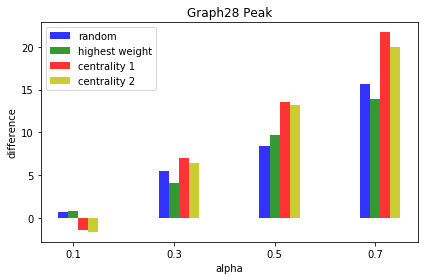

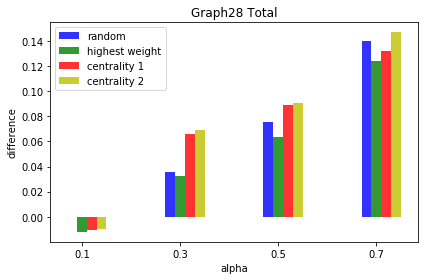

In [166]:
graph_lst = [28]
alphas = [0.1, 0.3, 0.5, 0.7]
dic ={}

for graph in graph_lst:
    print(graph)
    fname = "outfile"+str(graph)+".txt"
    ei,c_coeff, deg, mtx, edges, wor_map, loc_map = bipartite_graph(fname)
    mtx = normalize_lap(mtx)
    normal = SIR_simulation(fname, 0.2, 10, 10, 20, 4)
    temporal = large_temporal_graph(fname,alphas)
    original_peak =np.mean(normal[1])
    original_total=np.mean(normal[0])
    peaks_h = []
    peaks_ran = []
    totals_h = []
    totals_ran = []
    totals_c1 = []
    totals_c2 = []
    peaks_c1 = []
    peaks_c2 = []
    for alpha in alphas:
        print(alpha)
        
        c1 = SIR_simulation(fname, 0.2, 10, 10, 20, 4, temporal[alpha][0])
        total_c1, peak_c1 = np.mean(c1[0]),np.mean(c1[1])
        
        c2 = SIR_simulation(fname, 0.2, 10, 10, 20, 4, temporal[alpha][1])
        total_c2, peak_c2 = np.mean(c2[0]),np.mean(c2[1])

        mtx_hw = mtx.copy()
        h_w = highest_weight(edges,mtx_hw,alpha)
        h_w_edges_removed = mapping_edges(edges, h_w, wor_map, loc_map)

        mtx_ran = mtx.copy()
        ran = rand_edge(edges,alpha)
        ran_edges_removed = mapping_edges(edges,ran, wor_map, loc_map)

        hw =SIR_simulation(fname, 0.2, 10, 10, 20, 4, h_w_edges_removed)
        print("hw finished")
        r = SIR_simulation(fname, 0.2, 10, 10, 20, 4, ran_edges_removed)
        print("ran finishied")
        total_h, peak_h = np.mean(hw[0]),np.mean(hw[1])
        total_ran, peak_ran = np.mean(r[0]),np.mean(r[1])

        peaks_h.append(original_peak-peak_h)
        peaks_ran.append(original_peak-peak_ran)
        totals_h.append(original_total-total_h)
        totals_ran.append(original_total-total_ran)
        totals_c1.append(original_total-total_c1)
        totals_c2.append(original_total-total_c2)
        peaks_c1.append(original_peak-peak_c1)
        peaks_c2.append(original_peak-peak_c2)
    dic[graph] = [peaks_h, peaks_ran, totals_h, totals_ran, peaks_c1, peaks_c2, totals_c1, totals_c2]
    
 

    name = "graph_"+str(graph)+ "_static_data.txt"
    outfile = open(name, "w")
    print("original_peak",original_peak, file=outfile)
    print("original_total",original_total, file=outfile)
    print("random_peak",peaks_ran, file=outfile)
    print("highest_weight_peak",peaks_h, file=outfile)
    print("random_total",totals_ran, file=outfile)
    print("highest_weight_total",totals_h, file=outfile)

    outfile.close()

print("save figs")

alpha = np.array(["0.1","0.3", "0.5", "0.7"])
index = np.array([0,1,2,3])
opacity=0.8
bar_width=0.1

for graph in graph_lst:
    fig, ax = plt.subplots()


    rects1 = plt.bar(index, dic[graph][1], bar_width,
    alpha=opacity,
    color='b',
    label='random')

    rects2 = plt.bar(index+bar_width, dic[graph][0], bar_width,
    alpha=opacity,
    color='g',
    label='highest weight')
    
    rects3 = plt.bar(index+bar_width*2, dic[graph][4], bar_width,
    alpha=opacity,
    color='r',
    label='centrality 1')
    
    rects4 = plt.bar(index+bar_width*3, dic[graph][5], bar_width,
    alpha=opacity,
    color='y',
    label='centrality 2')

    plt.xlabel('alpha')
    plt.ylabel('difference')
    title = "Graph" + str(graph) + " Peak"
    plt.title(title)
    plt.xticks(index + bar_width, alpha)
    plt.legend()

    plt.tight_layout()
    plt.show()
    name = "graph_"+str(graph)+"_peak.png"
    fig.savefig(name)
    plt.close()

    fig, ax = plt.subplots()


    rects1 = plt.bar(index, dic[graph][3], bar_width,
    alpha=opacity,
    color='b',
    label='random')

    rects2 = plt.bar(index+bar_width, dic[graph][2], bar_width,
    alpha=opacity,
    color='g',
    label='highest weight')
    
    rects3 = plt.bar(index+bar_width*2, dic[graph][6], bar_width,
    alpha=opacity,
    color='r',
    label='centrality 1')
    
    rects4 = plt.bar(index+bar_width*3, dic[graph][7], bar_width,
    alpha=opacity,
    color='y',
    label='centrality 2')

    plt.xlabel('alpha')
    plt.ylabel('difference')
    title = "Graph" + str(graph) + " Total"
    plt.title(title)
    plt.xticks(index + bar_width, alpha)
    plt.legend()

    plt.tight_layout()
    plt.show()
    name = "graph_"+str(graph)+"_total.png"
    fig.savefig(name)
    plt.close()


In [389]:
import tensorflow

ModuleNotFoundError: No module named 'tensorflow'